In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from keras.models import Model, load_model, Sequential
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator

import re

import matplotlib.pyplot as plt

DATA_DIR = 'dataset_50_class/'
TRAIN_DIR = 'train_50_class/'
TEST_DIR = 'test_50_class/'
IMG_SIZE = 128

Using TensorFlow backend.


In [2]:
def get_dict():
    MAPPING_DICT = {}
    i = 0

    for class_label in os.listdir(DATA_DIR):
        MAPPING_DICT[i] = class_label
        i += 1
#     print(MAPPING_DICT)
    
    return MAPPING_DICT

In [3]:
mapping_dict = get_dict()

In [4]:
def label_img(img):
    img_class = re.split("[_.]", img)[1]    
    i = 0
    
    for key,val in mapping_dict.items():
        if val == img_class:
            i = key
            break
    
    a = [0 for j in range(50)]
    
    a[i] = 1
    
    return a

In [5]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [6]:
# train = create_train_data()
train = np.load("train_data.npy", allow_pickle=True)
print(train[0])

[array([[[230, 182, 130],
        [231, 182, 132],
        [232, 183, 133],
        ...,
        [250, 247, 243],
        [250, 247, 243],
        [250, 246, 245]],

       [[233, 184, 134],
        [234, 185, 135],
        [237, 188, 138],
        ...,
        [249, 248, 247],
        [247, 246, 245],
        [248, 248, 246]],

       [[234, 187, 136],
        [236, 189, 138],
        [234, 185, 135],
        ...,
        [247, 247, 247],
        [248, 248, 248],
        [247, 247, 247]],

       ...,

       [[ 51,  56,  61],
        [ 42,  44,  45],
        [ 60,  64,  68],
        ...,
        [ 44,  44,  46],
        [ 56,  58,  59],
        [ 42,  44,  46]],

       [[ 44,  47,  50],
        [ 42,  45,  46],
        [ 56,  55,  57],
        ...,
        [ 54,  54,  61],
        [ 57,  57,  61],
        [ 57,  57,  61]],

       [[ 62,  63,  61],
        [ 60,  63,  61],
        [ 62,  63,  61],
        ...,
        [ 41,  39,  44],
        [ 41,  38,  40],
        [ 45,  43,  42]

In [7]:
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        label = label_img(img)
        path = os.path.join(TEST_DIR,img)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),np.array(label)])
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [8]:
# test = create_test_data()
test = np.load("test_data.npy", allow_pickle=True)
print(test[0])

[array([[[ 34,  56,  47],
        [ 36,  69,  58],
        [ 55,  96,  85],
        ...,
        [ 30,  46,  30],
        [ 39,  47,  36],
        [ 41,  51,  39]],

       [[ 41,  54,  43],
        [ 32,  53,  41],
        [ 35,  60,  50],
        ...,
        [ 42,  54,  42],
        [ 30,  38,  28],
        [ 28,  33,  24]],

       [[ 54,  63,  53],
        [ 39,  55,  44],
        [ 36,  57,  48],
        ...,
        [ 43,  59,  43],
        [ 32,  41,  31],
        [ 35,  37,  30]],

       ...,

       [[227, 172,  97],
        [206, 149,  56],
        [212, 147,  47],
        ...,
        [223, 168,  77],
        [232, 172,  82],
        [229, 165,  70]],

       [[197, 139,  39],
        [209, 151,  47],
        [190, 134,  43],
        ...,
        [204, 150,  52],
        [214, 154,  54],
        [215, 154,  54]],

       [[225, 168,  75],
        [244, 190, 109],
        [190, 137,  43],
        ...,
        [203, 143,  43],
        [214, 153,  59],
        [194, 137,  48]

In [9]:
train_X_list = []
train_Y_list = []
test_X_list = []
test_Y_list = []

In [10]:
for i in range(len(train)):
    train_X_list.append(train[i][0].reshape(IMG_SIZE, IMG_SIZE, 3))
    train_Y_list.append(train[i][1])

for i in range(len(test)):
    test_X_list.append(test[i][0].reshape(IMG_SIZE, IMG_SIZE, 3))
    test_Y_list.append(test[i][1])

In [11]:
train_X = np.array(train_X_list)
train_Y = np.array(train_Y_list)
test_X = np.array(test_X_list)
test_Y = np.array(test_Y_list)

In [29]:
model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=train_X.shape[1:], pooling='max', classes=50)

In [19]:
# model.save("vgg16.h5")
model = load_model("vgg16.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [20]:
for layer in model.layers[:-5]:
    layer.trainable = False
    
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000022A70E03F60> False
<keras.layers.convolutional.Conv2D object at 0x0000022A70E03F28> False
<keras.layers.convolutional.Conv2D object at 0x0000022A70E16BA8> False
<keras.layers.pooling.MaxPooling2D object at 0x0000022A70E166A0> False
<keras.layers.convolutional.Conv2D object at 0x0000022A70E16F28> False
<keras.layers.convolutional.Conv2D object at 0x0000022A70E29390> False
<keras.layers.pooling.MaxPooling2D object at 0x0000022A70E29BA8> False
<keras.layers.convolutional.Conv2D object at 0x0000022A70E03828> False
<keras.layers.convolutional.Conv2D object at 0x0000022A70E3D668> False
<keras.layers.convolutional.Conv2D object at 0x0000022A70E3D630> False
<keras.layers.pooling.MaxPooling2D object at 0x0000022A70E52668> False
<keras.layers.convolutional.Conv2D object at 0x0000022A70E52080> False
<keras.layers.convolutional.Conv2D object at 0x0000022A70E52F28> False
<keras.layers.convolutional.Conv2D object at 0x0000022A70E664A8> False
<ker

In [21]:
model_final = Sequential()

model_final.add(model)
model_final.add(Dense(512, activation='relu', name='fc1'))
model_final.add(Dropout(rate=0.4))
model_final.add(Dense(512, activation='relu', name='fc2'))
model_final.add(Dropout(rate=0.4))
model_final.add(Dense(50, activation='softmax', name='fc3'))

model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
fc1 (Dense)                  (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
fc3 (Dense)                  (None, 50)                25650     
Total params: 15,265,650
Trainable params: 7,630,386
Non-trainable params: 7,635,264
_________________________________________________________

In [22]:
adam = Adam(lr=0.0001)

model_final.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
hist = model_final.fit(train_X, train_Y, epochs=5, validation_data=(test_X, test_Y), verbose=2)

Train on 19138 samples, validate on 8233 samples
Epoch 1/5
 - 111s - loss: 0.5809 - acc: 0.8310 - val_loss: 0.6274 - val_acc: 0.8297
Epoch 2/5
 - 111s - loss: 0.4114 - acc: 0.8785 - val_loss: 0.5442 - val_acc: 0.8562
Epoch 3/5
 - 111s - loss: 0.3163 - acc: 0.9027 - val_loss: 0.4647 - val_acc: 0.8781
Epoch 4/5
 - 111s - loss: 0.2801 - acc: 0.9126 - val_loss: 0.4768 - val_acc: 0.8717
Epoch 5/5
 - 111s - loss: 0.2147 - acc: 0.9281 - val_loss: 0.4093 - val_acc: 0.8847


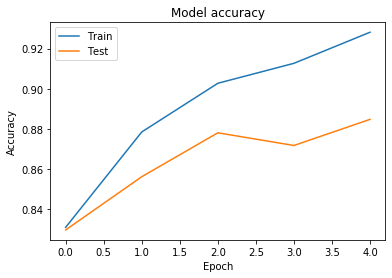

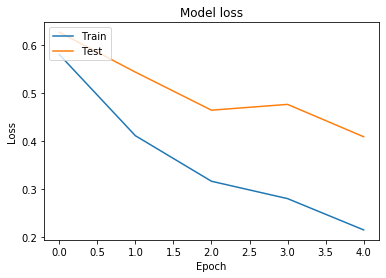

In [26]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [4]:
model_final.save("vgg16_50class.h5")
# model_final = load_model("vgg16_50class.h5")






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
predict = model_final.evaluate(test_X, test_Y, verbose=2)

print("loss = " + str(predict[0]))
print("accuracy = " + str(predict[1]))

loss = 0.496843677381076
accuracy = 0.8716142354086249


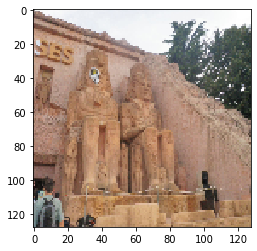

In [10]:
img_path = "dataset_50_class/95/2b2f209acc1ad858.jpg"

img = cv2.imread(img_path)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [11]:
pred = model_final.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3))[0].tolist()
pred_index = pred.index(max(pred))
print(mapping_dict[pred_index])
# print

95
